In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/hbase-0.94.0.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train_numeric.shape)
print(X_test_numeric.shape)

(847, 65)
(212, 65)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 673 samples
  Minority class (True): 174 samples
  Imbalance ratio: 1:3.87

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 673 -> 423 samples
Reduction: 62.9%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 174}
Cluster weights: {0: 1.0}
Cluster 0: 174 -> 423 samples
Minority class: 174 -> 423 samples
Change: 243.1%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final distribution:
  Class False: 423 samples
  Class True: 423 samples
Total samples: 846
Bala

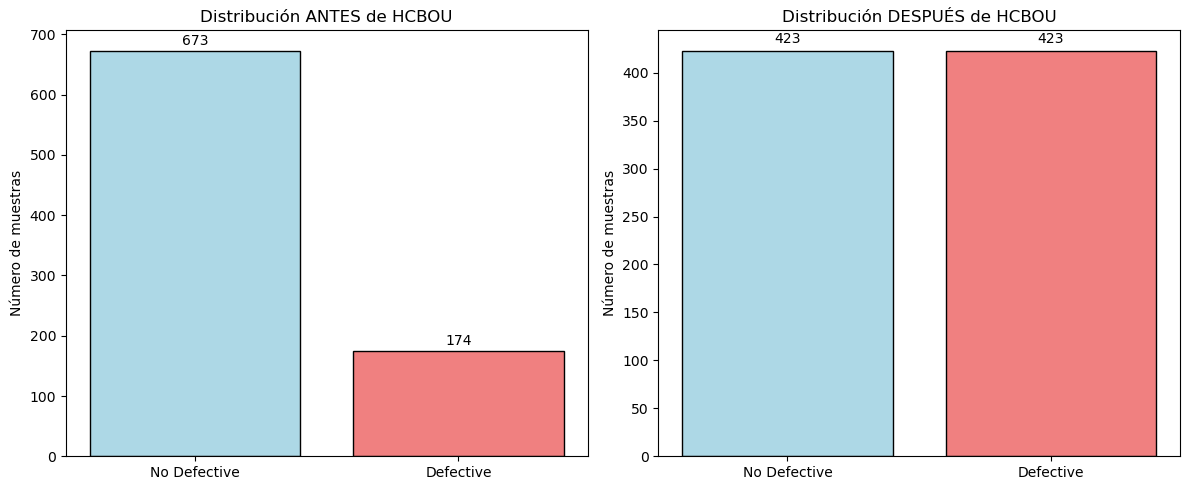


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (846, 65)
Shape final y_train_balanced: (846,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns, index=X_test_numeric.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,...,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,2.730496,11.316785,431.104019,6.166667,2.165485,1.100473,4.172577,48.473995,1.91844,15.449173,...,5.823877,2.163121,160.656028,80.598109,0.793989,0.658536,0.109929,1.910165,2.044917,1.456265
std,5.277680,8.289803,649.517799,5.617123,5.910059,0.410599,9.587146,99.699269,1.21790,10.706925,...,9.007345,1.525130,312.564110,230.241019,0.191033,0.250162,0.594627,1.166176,1.250937,1.870949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,131.000000,2.000000,0.000000,1.000000,0.000000,9.000000,1.00000,9.000000,...,1.000000,1.000000,7.000000,0.000000,0.644624,0.500000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,10.000000,257.000000,5.000000,0.000000,1.000000,2.000000,24.000000,2.00000,14.000000,...,3.000000,2.000000,40.500000,9.000000,0.860089,0.644468,0.000000,2.000000,2.000000,1.000000
75%,3.000000,14.000000,453.750000,8.000000,1.000000,1.000000,5.000000,45.000000,2.00000,20.000000,...,6.000000,3.000000,158.000000,46.000000,0.964933,0.917803,0.000000,2.000000,3.000000,2.000000
max,44.000000,97.000000,9624.000000,42.000000,39.000000,4.000000,139.000000,2028.000000,13.00000,137.000000,...,87.000000,9.000000,2916.000000,2469.000000,1.000000,1.000000,5.000000,9.000000,7.000000,11.000000


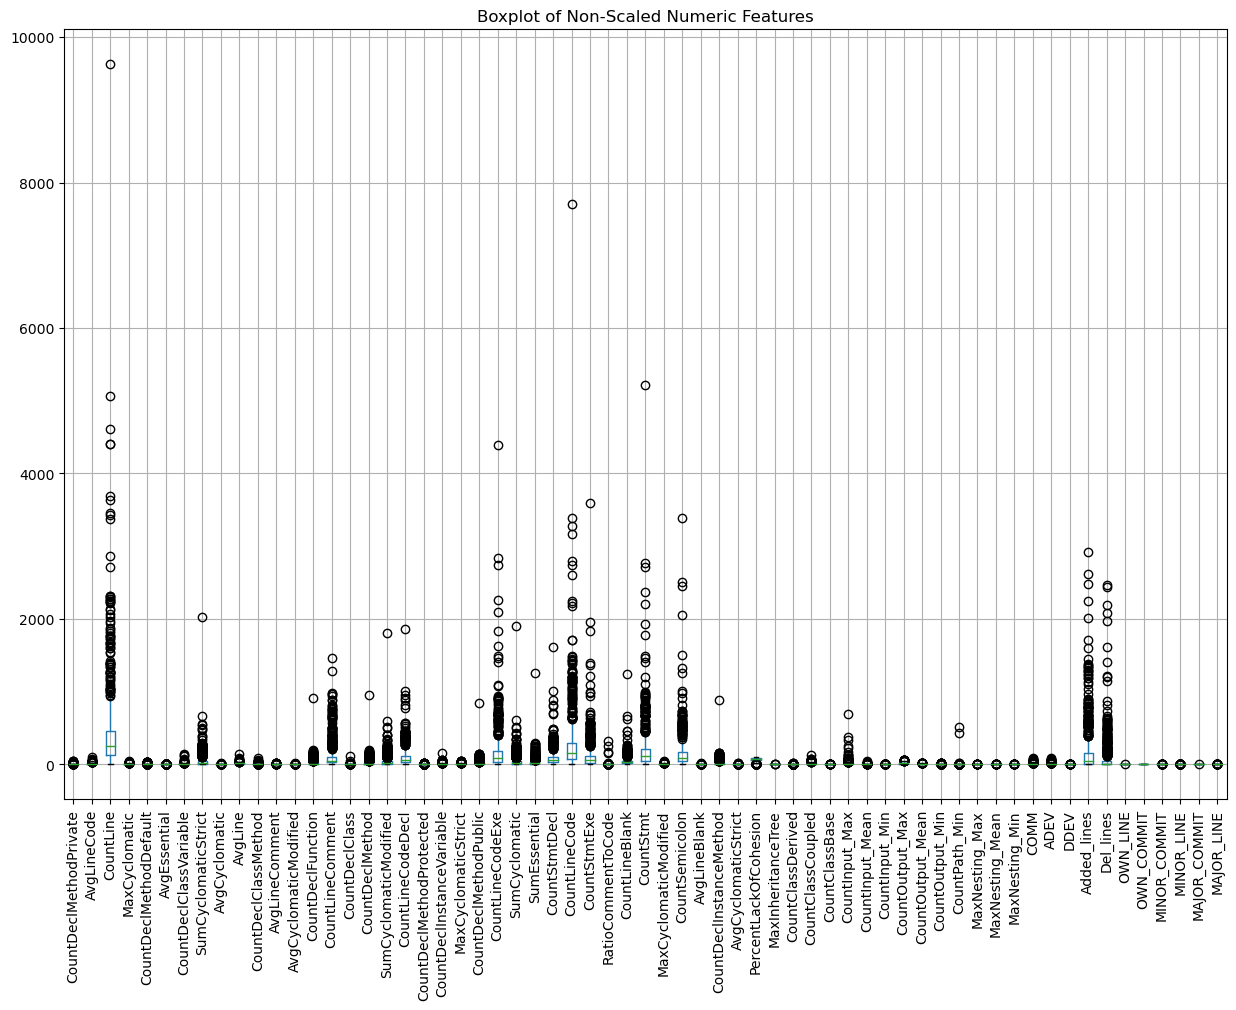

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,...,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,8.460000e+02,846.000000,8.460000e+02
mean,6.719080e-17,-1.679770e-17,-1.679770e-17,-8.398850e-17,3.359540e-17,6.509109e-17,8.398850e-18,-2.519655e-17,-1.469799e-17,1.679770e-17,...,-3.359540e-17,6.719080e-17,1.679770e-17,1.679770e-17,-1.007862e-16,-1.511793e-16,-3.359540e-17,-1.007862e-16,0.000000,-6.719080e-17
std,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,...,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592e+00,1.000592,1.000592e+00
min,-5.176728e-01,-1.365953e+00,-6.641220e-01,-1.098483e+00,-3.666234e-01,-2.681750e+00,-4.354836e-01,-4.864897e-01,-1.576135e+00,-1.443768e+00,...,-6.469523e-01,-1.419157e+00,-5.142979e-01,-3.502668e-01,-4.158749e+00,-2.633998e+00,-1.849799e-01,-1.638942e+00,-1.635675,-7.788165e-01
25%,-5.176728e-01,-6.417439e-01,-4.623146e-01,-7.422183e-01,-3.666234e-01,-2.448429e-01,-4.354836e-01,-3.961648e-01,-7.545635e-01,-6.026929e-01,...,-5.358661e-01,-7.630879e-01,-4.918892e-01,-3.502668e-01,-7.823465e-01,-6.341095e-01,-1.849799e-01,-7.809315e-01,-0.835802,-7.788165e-01
50%,-3.280836e-01,-1.589379e-01,-2.682098e-01,-2.078211e-01,-3.666234e-01,-2.448429e-01,-2.267476e-01,-2.456234e-01,6.700757e-02,-1.354292e-01,...,-3.136937e-01,-1.070184e-01,-3.846478e-01,-3.111542e-01,3.462143e-01,-5.627012e-02,-1.849799e-01,7.707895e-02,-0.035928,-2.440123e-01
75%,5.109498e-02,3.238681e-01,3.488646e-02,3.265760e-01,-1.973202e-01,-2.448429e-01,8.635652e-02,-3.486535e-02,6.700757e-02,4.252873e-01,...,1.956482e-02,5.490511e-01,-8.502574e-03,-1.503580e-01,8.953665e-01,1.037010e+00,-1.849799e-01,7.707895e-02,0.763945,2.907919e-01
max,7.824255e+00,1.034209e+01,1.416179e+01,6.383077e+00,6.236199e+00,7.065879e+00,1.407167e+01,1.986672e+01,9.104289e+00,1.135926e+01,...,9.017546e+00,4.485468e+00,8.820507e+00,1.037962e+01,1.079039e+00,1.365780e+00,8.228621e+00,6.083152e+00,3.963439,5.104029e+00


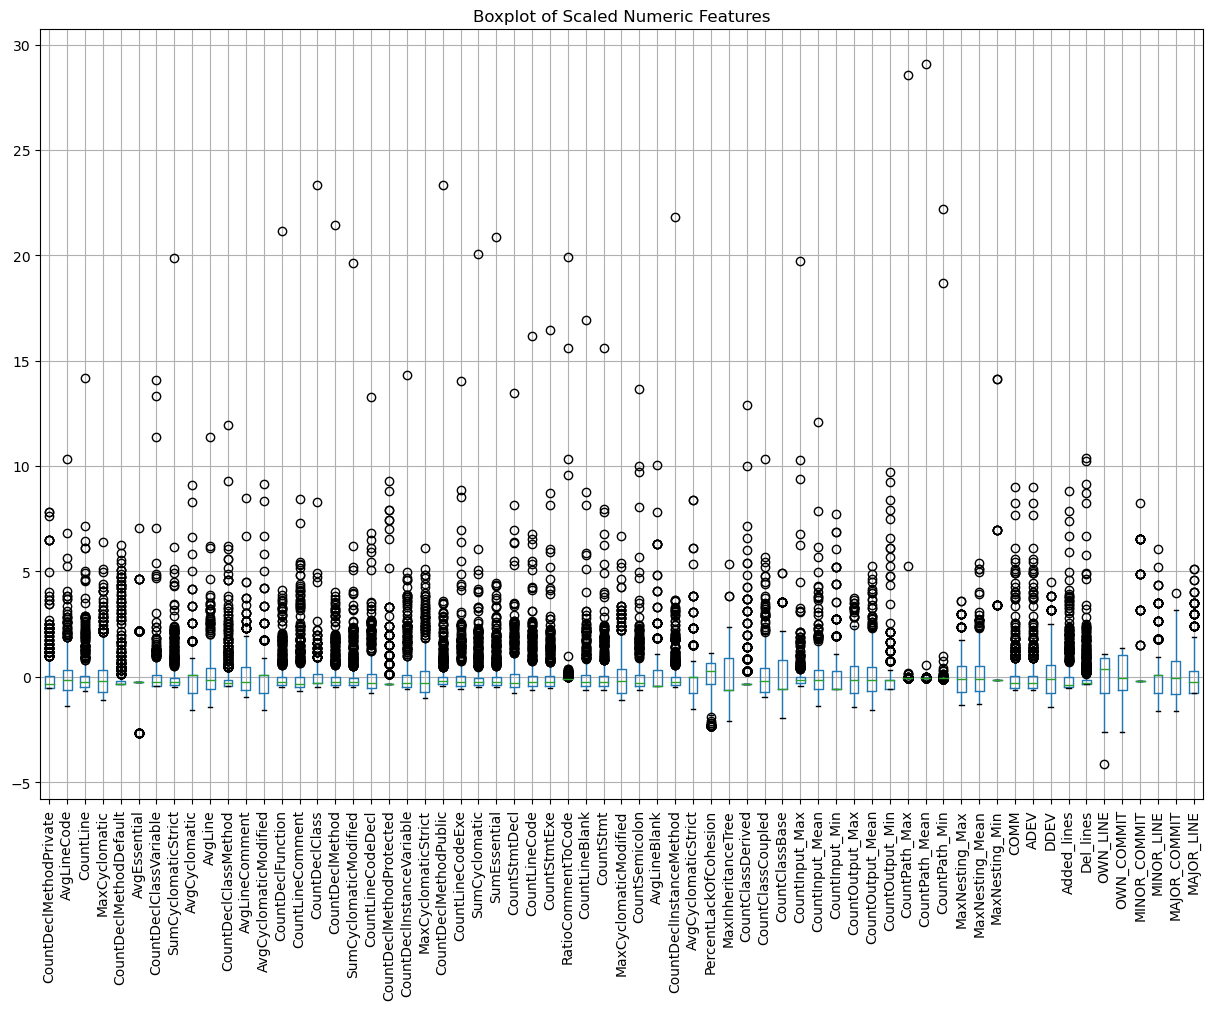

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Export the balanced and scaled training set to CSV files
X_train_balanced_scaled.to_csv('../classification/hcbou/hbase-0.94.0-hcbou-train-features-balanced-scaled.csv', index=False)
y_train_balanced.to_csv('../classification/hcbou/hbase-0.94.0-hcbou-train-labels-balanced.csv', index=False)
X_test_scaled.to_csv('../classification/hcbou/hbase-0.94.0-hcbou-test-features-scaled.csv', index=False)
y_test.to_csv('../classification/hcbou/hbase-0.94.0-hcbou-test-labels.csv', index=False)